<a href="https://colab.research.google.com/github/meghanas2806/my_repo/blob/main/3_HandsOn_Training_a_CNN_for_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercise: Training a CNN for Classification
Convolutional neural networks (CNN) are a type of artificial neural network especially designed for processing images, i.e. matrices of color intensity values. There are various kinds of layers in a CNN, but a typical architecture is to build a sequence of *convolutional* layers that find patterns in individual areas of the input matrix and *pooling* layers that aggregate these patterns. The final layers *flatten* the matrix data in order to perform classification with a standard *dense* or *fully connected* layer.

In this exercise we will consider CNNs for the classification of blood cells.

#### Importing Libraries and tools

In [1]:
!pip3 install numpy medmnist pandas scipy keras tf-keras-vis tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 27.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 31.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 25.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 80.3 MB/s eta 0:00:00
  Cr

In [2]:
import warnings

warnings.filterwarnings("ignore")

In [3]:
import time
from datetime import timedelta

import matplotlib.pyplot as plt
import medmnist
import numpy as np
import pandas as pd
import tensorflow as tf
from keras import layers
from keras import models
from keras.optimizers import Adam

from medmnist import BloodMNIST
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tf_keras_vis.activation_maximization import ActivationMaximization
from tf_keras_vis.activation_maximization.callbacks import Progress
from tf_keras_vis.activation_maximization.input_modifiers import Jitter, Rotate2D
from tf_keras_vis.utils.model_modifiers import ExtractIntermediateLayer, ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore

## Utility functions

In [4]:
def show_history_plots_of_trained_model(history, fill_between=True) -> None:
    acc = history.history["sparse_categorical_accuracy"]
    val_acc = history.history["val_sparse_categorical_accuracy"]

    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    epochs_range = range(len(val_loss))

    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label="training accuracy")
    plt.plot(epochs_range, val_acc, label="validation accuracy")
    if fill_between:
        plt.fill_between(epochs_range, acc, val_acc, color="lightpink", alpha=0.4, hatch="-", label="difference")
    plt.legend(loc="lower right")
    plt.title("training and validation accuracy")

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label="training loss")
    plt.plot(epochs_range, val_loss, label="validation loss")
    if fill_between:
        plt.fill_between(epochs_range, loss, val_loss, color="lightpink", alpha=0.4, hatch="-", label="difference")
    plt.legend(loc="upper right")
    plt.title("training and validation loss")
    plt.show()

# Data exploration

First we should inspect the metadata to get more insights into what kind of data we are dealing with.

In [5]:
medmnist.INFO["bloodmnist"]

{'python_class': 'BloodMNIST',
 'description': 'The BloodMNIST is based on a dataset of individual normal cells, captured from individuals without infection, hematologic or oncologic disease and free of any pharmacologic treatment at the moment of blood collection. It contains a total of 17,092 images and is organized into 8 classes. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source images with resolution 3×360×363 pixels are center-cropped into 3×200×200, and then resized into 3×28×28.',
 'url': 'https://zenodo.org/records/10519652/files/bloodmnist.npz?download=1',
 'MD5': '7053d0359d879ad8a5505303e11de1dc',
 'url_64': 'https://zenodo.org/records/10519652/files/bloodmnist_64.npz?download=1',
 'MD5_64': '2b94928a2ae4916078ca51e05b6b800b',
 'url_128': 'https://zenodo.org/records/10519652/files/bloodmnist_128.npz?download=1',
 'MD5_128': 'adace1e0ed228fccda1f39692059dd4c',
 'url_224': 'https://zenodo.org/records/10519652/files/bloodmnist

From looking at the description and the label field, we discover that we have images of normal blood cells organized into 8 classes including types of white/red blood cells and blood platelets. Now we download the data for the train, validation, test splits and define what size of images we want to use. Since this is a benchmark dataset, the splits are predefined to enable comparisons between studies.

In [6]:
train = BloodMNIST(split="train", download=True, as_rgb=True, size=28)
val = BloodMNIST(split="val", download=True, as_rgb=True, size=28)
test = BloodMNIST(split="test", download=True, as_rgb=True, size=28)

100%|██████████| 35.5M/35.5M [00:18<00:00, 1.87MB/s]


In [7]:
np.unique(train.labels)

array([0, 1, 2, 3, 4, 5, 6, 7], dtype=uint8)

As we can see, the labels are indeed integers. We can create our own map so we do not have to deal with class indices during exploration and evaluation.

In [8]:
labels = {int(label_idx): label_name  # since we have strings in the metadata
          for label_idx, label_name in medmnist.INFO["bloodmnist"]["label"].items()}
labels

{0: 'basophil',
 1: 'eosinophil',
 2: 'erythroblast',
 3: 'immature granulocytes(myelocytes, metamyelocytes and promyelocytes)',
 4: 'lymphocyte',
 5: 'monocyte',
 6: 'neutrophil',
 7: 'platelet'}

Lets change the name of label 3 to something more concise so we have no clutter in our plots:

In [9]:
labels[3] = "immature granulocytes"

In [10]:
train.imgs[0][0][:10]

array([[250, 223, 206],
       [255, 229, 212],
       [251, 222, 206],
       [229, 197, 182],
       [206, 170, 156],
       [196, 158, 145],
       [202, 162, 150],
       [209, 170, 155],
       [212, 173, 158],
       [201, 162, 145]], dtype=uint8)

The images seem to be scaled between 0-255 in RGB. Since we pass them to a CNN, which operates in floating point, we should scale the images to a float between 0 and 1.

In [11]:
train.imgs = train.imgs / 255.0
val.imgs = val.imgs / 255.0
test.imgs = test.imgs / 255.0

To get an intuition what a model should learn, we can plot a few example for each label

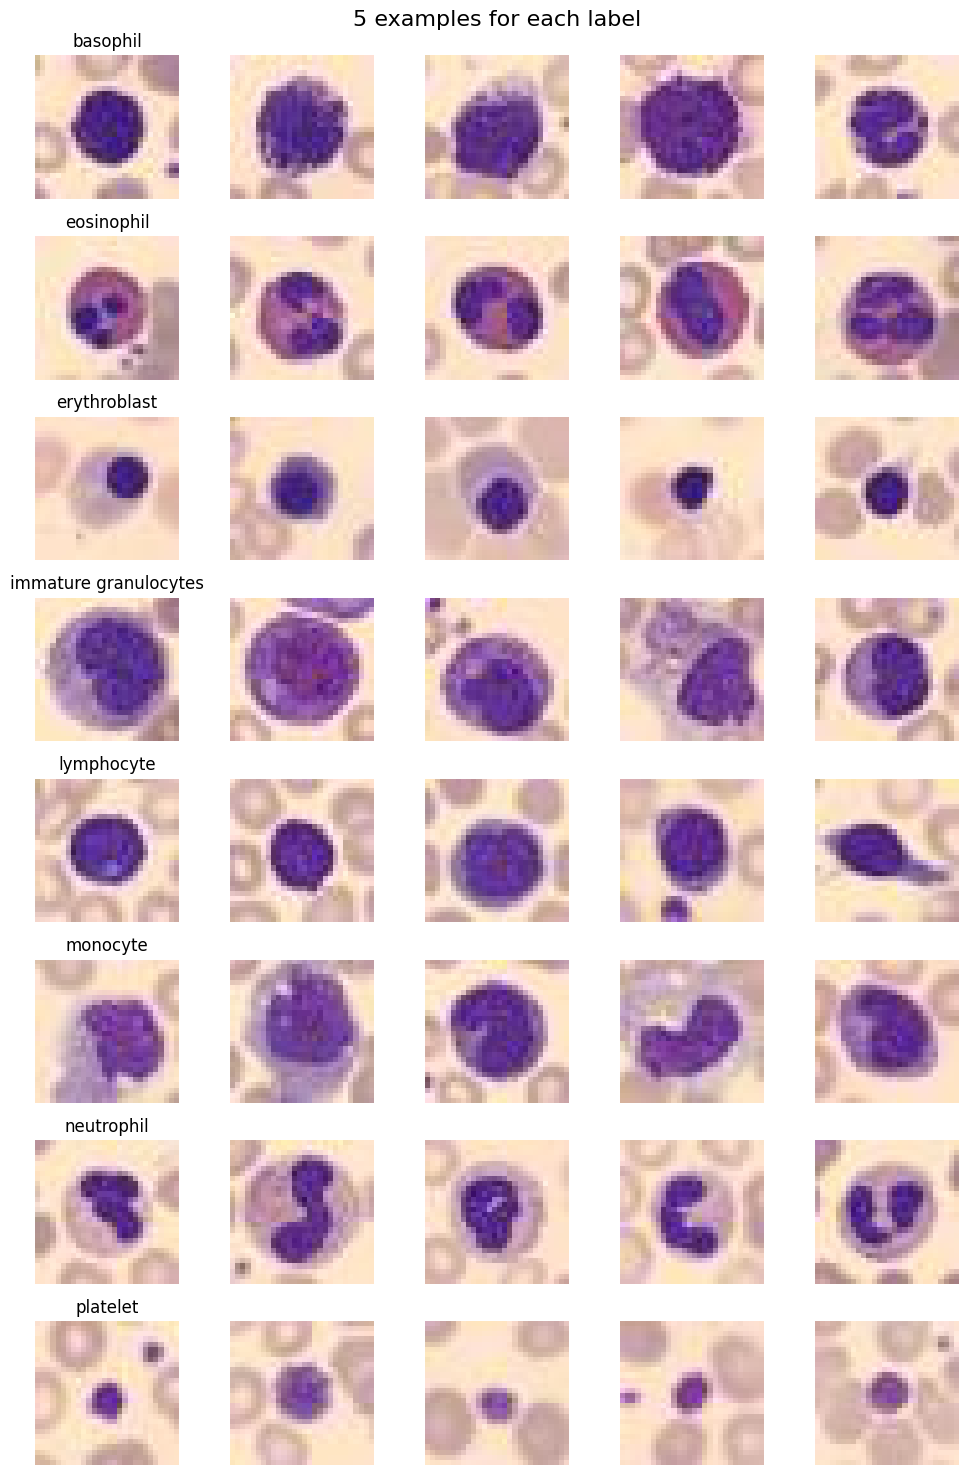

In [12]:
# Prepare a dictionary to store 5 examples for each label
examples = {label: [] for label in labels.keys()}

# Collect 5 examples for each label
for img, lbl in zip(train.imgs, train.labels):
    if len(examples[lbl[0]]) < 5:
        examples[lbl[0]].append(img)

# Plotting
fig, axs = plt.subplots(8, 5, figsize=(10, 15))
fig.suptitle("5 examples for each label", fontsize=16)

for label, example_images in examples.items():
    for i, img in enumerate(example_images):
        ax = axs[label, i]
        ax.imshow(img, vmin=0, vmax=1)  # Assuming grayscale images, adjust if needed
        ax.axis('off')
        if i == 0:
            ax.set_title(labels[label], fontsize=12)

plt.tight_layout()
plt.subplots_adjust(top=0.95)  # Adjust top for main title
plt.show()

Note that every good machine learning engineer should at this point check for potential issues in the data, and preprocess it as appropriate.
In this guided exercise we will completely ignore this phase; please **never** do this with real data.

We can see that there is definitely some difference between the classes even visible for a layperson. Thus we are confident, that we can build a classifier using a CNN.

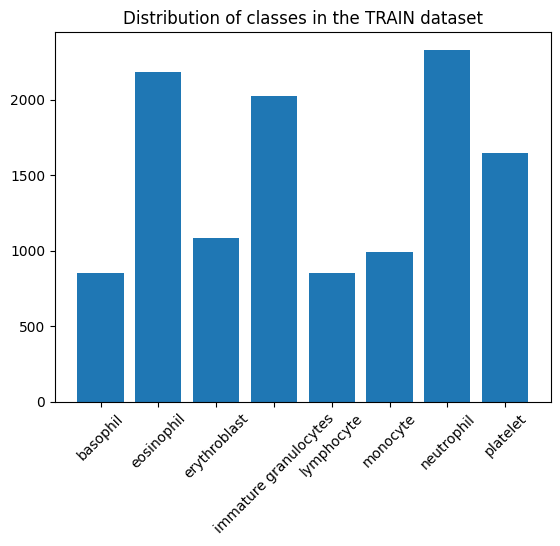

In [13]:
def count_labels(labels, classnames):
    classnames = list(classnames)
    dictionary = dict.fromkeys(classnames, 0)
    for label in labels:
        dictionary[classnames[label[0]]] += 1
    return dictionary


class_counts = count_labels(train.labels, labels.values())
plt.bar(class_counts.keys(), class_counts.values())
plt.xticks(rotation=45)
_ = plt.title("Distribution of classes in the TRAIN dataset")

As we can see, the dataset is not that well balanced, we can calculate the class weights based on the training distribution to increase the weight of rare samples in the loss. This way we can avoid, that our model actively learns the above class distribution and consequently focuses more on learning the difference between classes.

**Exercise 1**

> Adapt the three last code lines in the cell above to display the class labels distribution in the validation set.

In [14]:
# add your code here ...

**Click on the dots to display the solution**

In [ ]:
#@title Solution for Exercise 1
class_counts = count_labels(val.labels, labels.values())
plt.bar(class_counts.keys(), class_counts.values())
plt.xticks(rotation=45)
_ = plt.title("Distribution of classes in the VALIDATION dataset")
plt.show()

class_counts = count_labels(test.labels, labels.values())
plt.bar(class_counts.keys(), class_counts.values())
plt.xticks(rotation=45)
_ = plt.title("Distribution of classes in the TEST dataset")
plt.show()

It looks like the distributions are the same over all splits, so we do not have to adjust the class weights.

In [ ]:
train.labels

# Modeling

Since we may not have a GPU available, we will illustrate the procedure with rather small models. Our goal is not to get optimal performance on the dataset, but to showcase the procedure and tools for setting up the training of a CNN for classification.

We need the image size to define our model inputs.

In [ ]:
input_shape = train.imgs[0].shape
input_shape

The image is 64 pixels wide and tall and has 3 channels (RGB).

**Exercise 2**
> Build a CNN model using `models.Sequential`, `layers.Conv2D`, `layers.MaxPool2D`, `layers.Flatten()`, `layers.Dense`
> It should follow the following structure:
> * 3 convolution layers (2D) with max-pooling
>     1. 32 filters, 3x3 kernel, ReLU, 2x2 max-pooling
>     2. 64 filters, 3x3 kernel, ReLU, 2x2 max-pooling  
>     3. 64 filters, 3x3 kernel, ReLU, 2x2 max-pooling
> * 2 Fully connected layers
>     1. 128 neurons, ReLU
>     2. Number of output classes as neurons and softmax activation
>
> After the convolutional layers you will need to flatten the output to pass it to a fully-connected layer.
> Look up the corresponding function in the keras docs https://keras.io/api/layers/.

In [ ]:
tf.random.set_seed(842)

model = models.Sequential([
    ### START YOUR CODE ###
    # ...
    ### END YOUR CODE ###
])

**Click on the dots to display the solution**

In [ ]:
#@title Solution for Exercise 2
tf.random.set_seed(842)

model = models.Sequential([
    ### START YOUR CODE ###
    layers.Conv2D(32, (3, 3), activation="relu", padding="same", input_shape=input_shape),
    layers.MaxPool2D(pool_size=(2, 2)),
    layers.Conv2D(64, (3, 3), activation="relu"),
    layers.MaxPool2D(pool_size=(2, 2)),
    layers.Conv2D(64, (3, 3), activation="relu"),
    layers.MaxPool2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(256, activation="relu"),
    layers.Dense(len(labels), activation="softmax"),
    ### END YOUR CODE ###
])

Compile the model, using an optimizer, a loss function and desired metrics and provide an optimizer that performs gradient descent with a defined learning rate

In [ ]:
learning_rate = 5e-5
opt = Adam(learning_rate=learning_rate)
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=["sparse_categorical_accuracy"])

In [ ]:
model.summary()

Here we define some helper functions to get the model weights for visualization

In [ ]:
def get_filter_weights(model: models.Sequential):
    filters = []
    for layer in model.layers:
        if 'conv' not in layer.name:
            continue
        f, _ = layer.get_weights()
        print(layer.name, f.shape)
        filters.append(f)
    return filters

In [ ]:
untrained_filters = get_filter_weights(model)
untrained_filters[0].shape

## Model training

Augmentation of images with standardisation, rotation and flipping to improve generalization.

In [ ]:
datagen = ImageDataGenerator(rotation_range=10, horizontal_flip=True, vertical_flip=True)

Now we fit the model by providing it the imagedatagenerator with our training data. We can use the early-stopping callback to stop the training once our validation scores have not improved in the last 5 epochs.

In [ ]:
tf.random.set_seed(42)
start = time.monotonic()
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss',
                                               mode='min',
                                               patience=20,
                                               restore_best_weights=True)
model.fit(datagen.flow(train.imgs, train.labels, batch_size=32),
          validation_data=(val.imgs, val.labels),
          shuffle=True,  # images provided by BloodMNIST should be shuffled, but we do it again just to be sure
          epochs=100,
          callbacks=[early_stopping])
train_time_s = time.monotonic() - start
print(f"Training time (s): {timedelta(seconds=train_time_s)}")

In [ ]:
show_history_plots_of_trained_model(model.history)

## Model evaluation

Here we evaluate our model. First we have to calculate the probabilities and labels on the test set

In [ ]:
true_labels = test.labels[:, 0]

**Exercise 3: Generate the predicted labels using your trained model**

In [ ]:
### START YOUR CODE ###
predicted_probabilities = ...
predicted_labels = ...
### END YOUR CODE ###

**Click on the dots to display the solution**

In [ ]:
#@title Solution for Exercise 3
predicted_probabilities = model.predict(test.imgs, verbose=0)
predicted_labels = np.argmax(predicted_probabilities, axis=-1)

Using scikit-learn, we can create a classification report that includes all important metrics off-the-shelf.

In [ ]:
report = classification_report(
    true_labels,
    predicted_labels,
    target_names=list(labels.values()),
    zero_division=0,
    output_dict=True
)

print(f"Accuracy: {report['accuracy']}")
metrics = {k: v for k, v in report.items() if k not in ['accuracy']}
df_report = pd.DataFrame(metrics).transpose()
df_report = df_report[['precision', 'recall', 'f1-score', 'support']].round(4)
df_report

In [ ]:
matrix = confusion_matrix(true_labels, predicted_labels)

ConfusionMatrixDisplay(matrix, display_labels=list(labels.values())).plot(cmap=plt.cm.Blues)
tick_marks = np.arange(len(list(labels.values())))
plt.xticks(tick_marks, list(labels.values()), rotation=45)
_ = plt.yticks(tick_marks, list(labels.values()))

## Model interpretation

Feature maps in Convolutional Neural Networks (CNNs) provide valuable insights into how the network processes and understands input data. They represent the output of convolutional layers and capture specific features or patterns in the input.

In [ ]:
example_idx = 20
example_label = train.labels[example_idx][0]
print(labels[example_label])
example_image = train.imgs[example_idx]
plt.imshow(example_image)

In [ ]:
layer_1_model = models.Model(inputs=model.inputs, outputs=model.layers[1].output)
feature_map_layer_1 = layer_1_model.predict(np.expand_dims(example_image, 0))[0].T

In [ ]:
feature_map_layer_1.shape

In [ ]:
def plot_feature_maps(feature_maps, figsize=(10, 10)) -> None:
    num_maps = len(feature_maps)
    num_rows = np.ceil(np.sqrt(num_maps)).astype(int)

    # Create a figure to display the filters
    fig, axes = plt.subplots(num_rows, num_rows, figsize=figsize)

    for i in range(num_maps):
        ax = axes[i // num_rows, i % num_rows]
        ax.imshow(feature_maps[i], cmap='gray', label=f"Feature map {i}")

    # Remove empty subplots
    for i in range(num_maps, num_rows * num_rows):
        fig.delaxes(axes.flatten()[i])

    plt.tight_layout()
    plt.show()

In [ ]:
plot_feature_maps(feature_map_layer_1)

### Activations

The idea behind activation maximization is to generate input data that leads to the highest possible activation for a particular neuron or filter within the network.
By examining the inputs that maximize activations, we can gain insights into what specific features or patterns different neurons are sensitive to.

Lets try it for neutrophils, an example of a neutrophil below

In [ ]:
plt.imshow(example_image)

Since filter at index 4 looks interesting, we will try to maximize its activation.

In [ ]:
import random

tf.random.set_seed(123)
np.random.seed(123)
random.seed(123)

activation_maximization = ActivationMaximization(model,
                                                 model_modifier=[ExtractIntermediateLayer(-1),
                                                                 ReplaceToLinear()],
                                                 clone=True)
rotator = Rotate2D(degree=2)
rotator.random_generator = np.random.default_rng(123)
activations = activation_maximization(CategoricalScore(example_label),
                                      steps=200,
                                      input_range=(0.0, 1.0),
                                      input_modifiers=[Jitter(jitter=10), rotator],
                                      optimizer=tf.keras.optimizers.AdamW(learning_rate=0.5),
                                      callbacks=[Progress()]).cpu().numpy()

plt.imshow(activations[0], cmap='gray')

In [ ]:
plt.imshow(example_image)
plt.show()

# Summary

In this exercise we have trained a CNN model for the classification of blood cells. We have used the medmnist dataset and a simple model architecture. We have also evaluated the model and visualized the feature maps and activations of the model